### Demonstration of `flopy.utils.get_transmissivities` method
for computing open interval transmissivities (for weighted averages of heads or fluxes)

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import flopy
import flopy.utils.binaryfile as bf
from flopy.utils import HydmodObs, get_transmissivities

mf = flopy.modflow
%matplotlib inline

### Make up some open interval tops and bottoms and some heads
* (these could be lists of observation well screen tops and bottoms)
* the heads array contains the simulated head in each model layer,
  at the location of each observation well. Or they might be the simulated
  heads for each column of cells containing a specified flux boundary condition.
* make up a model grid with uniform horizontal k of 2.

In [2]:
sctop = [-.25, .5, 1.7, 1.5, 3., 2.5]
scbot = [-1., -.5, 1.2, 0.5, 1.5, -.2]
heads = np.array([[1., 2.0, 2.05, 3., 4., 2.5],
                  [1.1, 2.1, 2.2, 2., 3.5, 3.],
                  [1.2, 2.3, 2.4, 0.6, 3.4, 3.2]
        ])
nl, nr = heads.shape
nc = nr
botm = np.ones((nl, nr, nc), dtype=float)
top = np.ones((nr, nc), dtype=float) * 2.1
hk = np.ones((nl, nr, nc), dtype=float) * 2.
for i in range(nl):
    botm[nl-i-1, :, :] = i
botm

array([[[ 2.,  2.,  2.,  2.,  2.,  2.],
        [ 2.,  2.,  2.,  2.,  2.,  2.],
        [ 2.,  2.,  2.,  2.,  2.,  2.],
        [ 2.,  2.,  2.,  2.,  2.,  2.],
        [ 2.,  2.,  2.,  2.,  2.,  2.],
        [ 2.,  2.,  2.,  2.,  2.,  2.]],

       [[ 1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.]],

       [[ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]]])

### Make a flopy modflow model

In [3]:
m = mf.Modflow('junk', version='mfnwt', model_ws='temp')
dis = mf.ModflowDis(m, nlay=nl, nrow=nr, ncol=nc, botm=botm, top=top)
upw = mf.ModflowUpw(m, hk=hk)

### Get transmissivities along the diagonal cells
* alternatively, if a model `SpatialReference` has been set up, the real-world x and y coordinates could be supplied with the `x` and `y` arguments
* if `sctop` and `scbot` arguments are given, the transmissivites are computed for the open intervals only
  (cells that are partially within the open interval have reduced thickness, cells outside of the open interval have transmissivities of 0). If no `sctop` or `scbot` arguments are supplied, trasmissivites reflect the full saturated thickness in each column of cells.

In [4]:
r, c = np.arange(nr), np.arange(nc)
T = get_transmissivities(heads, m, r=r, c=c, sctop=sctop, scbot=scbot)
np.round(T, 2)

array([[ 0. ,  0. ,  0. ,  0. ,  0.2,  0.2],
       [ 0. ,  0. ,  1. ,  1. ,  1. ,  2. ],
       [ 0. ,  1. ,  0. ,  0.2,  0. ,  2. ]])

In [5]:
m.dis.botm.array[:, r, c]

array([[ 2.,  2.,  2.,  2.,  2.,  2.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

### Plot the model top and layer bottoms (colors)

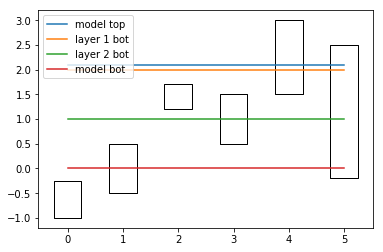

In [6]:
fig, ax = plt.subplots()
plt.plot(m.dis.top.array[r, c], label='model top')
for i, l in enumerate(m.dis.botm.array[:, r, c]):
    label = 'layer {} bot'.format(i+1)
    if i == m.nlay -1:
        label = 'model bot'
    plt.plot(l, label=label)
for iw in range(len(sctop)):
    ax.fill_between([iw-.25, iw+.25], scbot[iw], sctop[iw], 
                    facecolor='None', edgecolor='k')
ax.legend(loc=2)

### example of transmissivites without `sctop` and `scbot`

In [7]:
T = get_transmissivities(heads, m, r=r, c=c)
np.round(T, 2)

array([[ 0. ,  0. ,  0.1,  0.2,  0.2,  0.2],
       [ 0.2,  2. ,  2. ,  2. ,  2. ,  2. ],
       [ 2. ,  2. ,  2. ,  1.2,  2. ,  2. ]])